In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from pycocotools.coco import COCO
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch.nn.functional as F

D:\Anaconda\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 150        # number of epochs
LR = 0.00002         # Learning rate
BATCH_SIZE = 32    # Batch size 

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [3]:

def create_image_mask_dataframe(image_dir, annotation_file):

    coco = COCO(annotation_file)
    image_ids = list(coco.imgs.keys())

    data = []

    for image_id in image_ids:
        # Get image information
        image_info = coco.loadImgs(image_id)[0]
        image_path = f"{image_dir}/{image_info['file_name']}"


        annotation_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(annotation_ids)

        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for annotation in annotations:
            if 'segmentation' in annotation:
                mask = np.maximum(mask, coco.annToMask(annotation))

      
        data.append({
            "image_path": image_path,
            "mask": mask  # Alternatively, save masks to files and store paths
        })

   
    df = pd.DataFrame(data)
    return df


In [4]:
image_dir= 'd2s_images_v1/images'
annotation_file = 'd2s_annotations_v1.1/annotations/D2S_training.json'
df = create_image_mask_dataframe(image_dir, annotation_file)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [5]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.image_path

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample['mask']  # Access the mask column

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')  # Directly visualize the mask array
        ax[i].axis('off')  # Optionally turn off axes for clarity

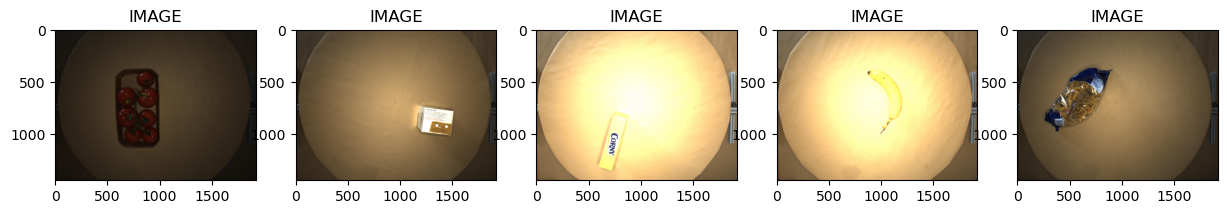

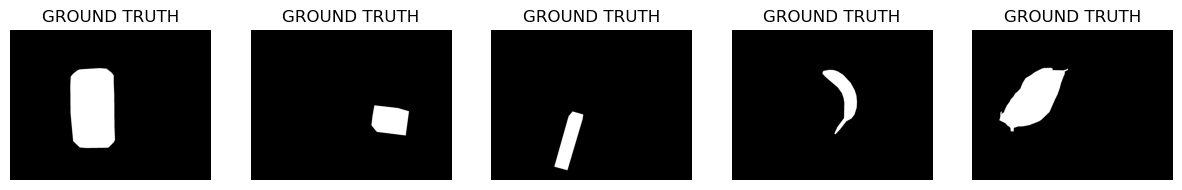

In [6]:
generate_sample_images(sample)
generate_sample_masks(sample)

In [7]:
sampled_df = df.sample(frac=0.004, random_state=57) 
train_df, val_df = train_test_split(sampled_df, test_size=0.2, random_state=57)
def trainData_augs():
    return A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
    ], is_check_shapes=False)

def valData_augs():
    return A.Compose([
        A.Resize(224, 224)
    ], is_check_shapes=False)

In [8]:
train_df

,image_path,mask
806,d2s_images_v1/images/D2S_005826.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3441,d2s_images_v1/images/D2S_019621.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1510,d2s_images_v1/images/D2S_010410.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1931,d2s_images_v1/images/D2S_013011.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1049,d2s_images_v1/images/D2S_006929.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
72,d2s_images_v1/images/D2S_000712.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3760,d2s_images_v1/images/D2S_020710.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1441,d2s_images_v1/images/D2S_009901.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
359,d2s_images_v1/images/D2S_003129.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
572,d2s_images_v1/images/D2S_005102.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [9]:
val_df

,image_path,mask
4149,d2s_images_v1/images/D2S_022009.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2981,d2s_images_v1/images/D2S_017711.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3690,d2s_images_v1/images/D2S_020500.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3934,d2s_images_v1/images/D2S_021304.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.image_path
        mask = sample['mask']

        # Read images and masks
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")
        if len(mask.shape) == 2:  # Add channel dimension if mask is grayscale
            mask = np.expand_dims(mask, axis=2)

        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # Normalize the images and masks
        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask) / 255.0

        return image, mask


In [11]:
train_data = SegmentationDataset(train_df, trainData_augs())
val_data = SegmentationDataset(val_df, valData_augs())
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 14
Size of Validset : 4


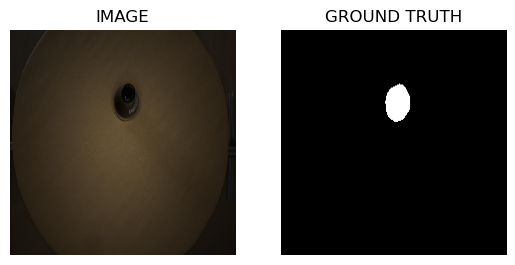

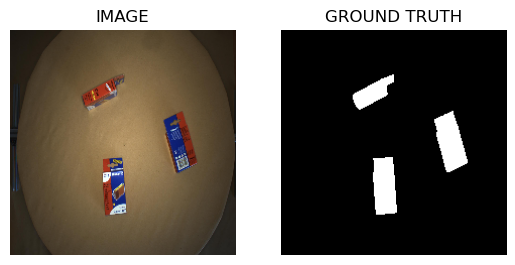

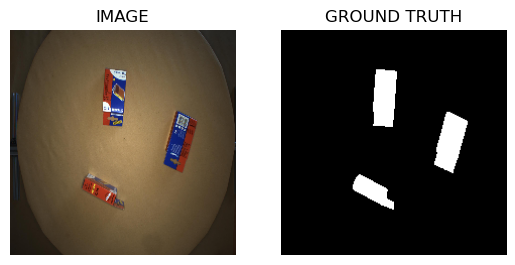

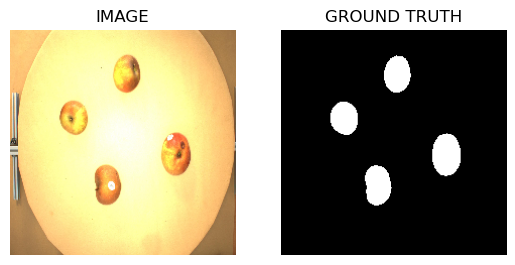

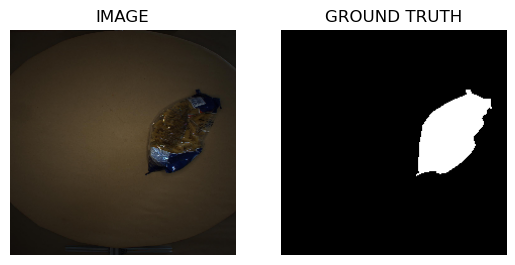

In [12]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Total number of batches in Train Loader: 1
Total number of batches in Val Loader: 1
Size of one batch of images: torch.Size([14, 3, 224, 224])
Size of one batch of masks: torch.Size([14, 1, 224, 224])


In [14]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits


In [15]:
model = SegmentationModel()
model.to(DEVICE);

In [16]:
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [17]:
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [18]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [19]:
# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.23it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.748120903968811 Val Loss 1.6924643516540527


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


MODEL SAVED
 Epoch 2 Train Loss 1.7396538257598877 Val Loss 1.6802304983139038


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.44it/s]


MODEL SAVED
 Epoch 3 Train Loss 1.7371047735214233 Val Loss 1.678297996520996


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


MODEL SAVED
 Epoch 4 Train Loss 1.7325828075408936 Val Loss 1.6777467727661133


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


 Epoch 5 Train Loss 1.730435848236084 Val Loss 1.6865873336791992


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


 Epoch 6 Train Loss 1.728140115737915 Val Loss 1.701614260673523


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


 Epoch 7 Train Loss 1.7231991291046143 Val Loss 1.718409538269043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


 Epoch 8 Train Loss 1.7244369983673096 Val Loss 1.7346546649932861


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


 Epoch 9 Train Loss 1.7192039489746094 Val Loss 1.7476731538772583


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s]


 Epoch 10 Train Loss 1.7159438133239746 Val Loss 1.7545084953308105


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


 Epoch 11 Train Loss 1.7162644863128662 Val Loss 1.758239984512329


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


 Epoch 12 Train Loss 1.7119909524917603 Val Loss 1.7589802742004395


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


 Epoch 13 Train Loss 1.7078759670257568 Val Loss 1.7571415901184082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]


 Epoch 14 Train Loss 1.7061042785644531 Val Loss 1.7538132667541504


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


 Epoch 15 Train Loss 1.7036683559417725 Val Loss 1.7495790719985962


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


 Epoch 16 Train Loss 1.7043766975402832 Val Loss 1.7424015998840332


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


 Epoch 17 Train Loss 1.69949209690094 Val Loss 1.735967755317688


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


 Epoch 18 Train Loss 1.697885274887085 Val Loss 1.728921890258789


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.11it/s]


 Epoch 19 Train Loss 1.6939483880996704 Val Loss 1.7214409112930298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


 Epoch 20 Train Loss 1.6935200691223145 Val Loss 1.713613510131836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


 Epoch 21 Train Loss 1.6890652179718018 Val Loss 1.7061245441436768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


 Epoch 22 Train Loss 1.6894586086273193 Val Loss 1.6998376846313477


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


 Epoch 23 Train Loss 1.6847577095031738 Val Loss 1.6943230628967285


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


 Epoch 24 Train Loss 1.6841325759887695 Val Loss 1.6897263526916504


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


 Epoch 25 Train Loss 1.6814031600952148 Val Loss 1.6856380701065063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


 Epoch 26 Train Loss 1.6804039478302002 Val Loss 1.6822752952575684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.59it/s]


 Epoch 27 Train Loss 1.676607608795166 Val Loss 1.6793699264526367


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


MODEL SAVED
 Epoch 28 Train Loss 1.6751357316970825 Val Loss 1.6771600246429443


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


MODEL SAVED
 Epoch 29 Train Loss 1.6735858917236328 Val Loss 1.6749675273895264


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


MODEL SAVED
 Epoch 30 Train Loss 1.669938325881958 Val Loss 1.6733440160751343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


MODEL SAVED
 Epoch 31 Train Loss 1.6699862480163574 Val Loss 1.6722192764282227


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


MODEL SAVED
 Epoch 32 Train Loss 1.6690869331359863 Val Loss 1.6706600189208984


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


MODEL SAVED
 Epoch 33 Train Loss 1.666661024093628 Val Loss 1.6698851585388184


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


MODEL SAVED
 Epoch 34 Train Loss 1.6676263809204102 Val Loss 1.669800043106079


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


MODEL SAVED
 Epoch 35 Train Loss 1.6633434295654297 Val Loss 1.6692405939102173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.24it/s]


MODEL SAVED
 Epoch 36 Train Loss 1.6594911813735962 Val Loss 1.6688451766967773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.20it/s]


MODEL SAVED
 Epoch 37 Train Loss 1.6586617231369019 Val Loss 1.6684954166412354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


MODEL SAVED
 Epoch 38 Train Loss 1.6567261219024658 Val Loss 1.6684412956237793


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.38it/s]


MODEL SAVED
 Epoch 39 Train Loss 1.655195713043213 Val Loss 1.6681709289550781


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


MODEL SAVED
 Epoch 40 Train Loss 1.6533658504486084 Val Loss 1.6675479412078857


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.56it/s]


MODEL SAVED
 Epoch 41 Train Loss 1.649427056312561 Val Loss 1.6668193340301514


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]


 Epoch 42 Train Loss 1.6493778228759766 Val Loss 1.6670962572097778


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


 Epoch 43 Train Loss 1.646394968032837 Val Loss 1.6668317317962646


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


 Epoch 44 Train Loss 1.6456692218780518 Val Loss 1.666900396347046


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


MODEL SAVED
 Epoch 45 Train Loss 1.6426246166229248 Val Loss 1.6667423248291016


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


MODEL SAVED
 Epoch 46 Train Loss 1.6408376693725586 Val Loss 1.6666760444641113


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]


 Epoch 47 Train Loss 1.6392308473587036 Val Loss 1.666856288909912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


MODEL SAVED
 Epoch 48 Train Loss 1.6385653018951416 Val Loss 1.6665709018707275


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


MODEL SAVED
 Epoch 49 Train Loss 1.636939287185669 Val Loss 1.6661267280578613


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


MODEL SAVED
 Epoch 50 Train Loss 1.6326333284378052 Val Loss 1.6657249927520752


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]


MODEL SAVED
 Epoch 51 Train Loss 1.6333210468292236 Val Loss 1.665398359298706


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


MODEL SAVED
 Epoch 52 Train Loss 1.6328532695770264 Val Loss 1.6652040481567383


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


MODEL SAVED
 Epoch 53 Train Loss 1.6299030780792236 Val Loss 1.6649670600891113


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s]


MODEL SAVED
 Epoch 54 Train Loss 1.6272265911102295 Val Loss 1.6645469665527344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


MODEL SAVED
 Epoch 55 Train Loss 1.6250797510147095 Val Loss 1.6635537147521973


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


MODEL SAVED
 Epoch 56 Train Loss 1.6244574785232544 Val Loss 1.6632201671600342


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


MODEL SAVED
 Epoch 57 Train Loss 1.6232273578643799 Val Loss 1.6629321575164795


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]


MODEL SAVED
 Epoch 58 Train Loss 1.6227164268493652 Val Loss 1.661815881729126


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.31it/s]


MODEL SAVED
 Epoch 59 Train Loss 1.6179423332214355 Val Loss 1.6607906818389893


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


MODEL SAVED
 Epoch 60 Train Loss 1.6147522926330566 Val Loss 1.6594786643981934


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s]


MODEL SAVED
 Epoch 61 Train Loss 1.6145203113555908 Val Loss 1.6578404903411865


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]


MODEL SAVED
 Epoch 62 Train Loss 1.6135728359222412 Val Loss 1.6570920944213867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


MODEL SAVED
 Epoch 63 Train Loss 1.6150226593017578 Val Loss 1.6559903621673584


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


MODEL SAVED
 Epoch 64 Train Loss 1.6091835498809814 Val Loss 1.6545569896697998


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


MODEL SAVED
 Epoch 65 Train Loss 1.6075479984283447 Val Loss 1.6531314849853516


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


MODEL SAVED
 Epoch 66 Train Loss 1.6059718132019043 Val Loss 1.651138424873352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


MODEL SAVED
 Epoch 67 Train Loss 1.6063616275787354 Val Loss 1.6491878032684326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


MODEL SAVED
 Epoch 68 Train Loss 1.604062795639038 Val Loss 1.6479226350784302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


MODEL SAVED
 Epoch 69 Train Loss 1.6010669469833374 Val Loss 1.646500587463379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.50it/s]


MODEL SAVED
 Epoch 70 Train Loss 1.600278615951538 Val Loss 1.645348310470581


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


MODEL SAVED
 Epoch 71 Train Loss 1.5980585813522339 Val Loss 1.6440551280975342


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


MODEL SAVED
 Epoch 72 Train Loss 1.5961205959320068 Val Loss 1.6422908306121826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.56it/s]


MODEL SAVED
 Epoch 73 Train Loss 1.5958389043807983 Val Loss 1.6407196521759033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.61it/s]


MODEL SAVED
 Epoch 74 Train Loss 1.595726490020752 Val Loss 1.638908863067627


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


MODEL SAVED
 Epoch 75 Train Loss 1.5930733680725098 Val Loss 1.6370813846588135


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


MODEL SAVED
 Epoch 76 Train Loss 1.5922088623046875 Val Loss 1.634951114654541


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


MODEL SAVED
 Epoch 77 Train Loss 1.5885674953460693 Val Loss 1.633307933807373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


MODEL SAVED
 Epoch 78 Train Loss 1.5863423347473145 Val Loss 1.6320159435272217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


MODEL SAVED
 Epoch 79 Train Loss 1.5854926109313965 Val Loss 1.6301546096801758


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


MODEL SAVED
 Epoch 80 Train Loss 1.5830215215682983 Val Loss 1.628113031387329


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]


MODEL SAVED
 Epoch 81 Train Loss 1.5823032855987549 Val Loss 1.6261684894561768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


MODEL SAVED
 Epoch 82 Train Loss 1.5808179378509521 Val Loss 1.6248749494552612


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


MODEL SAVED
 Epoch 83 Train Loss 1.5787367820739746 Val Loss 1.6232526302337646


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


MODEL SAVED
 Epoch 84 Train Loss 1.576909065246582 Val Loss 1.621853232383728


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.15it/s]


MODEL SAVED
 Epoch 85 Train Loss 1.5764248371124268 Val Loss 1.6201050281524658


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


MODEL SAVED
 Epoch 86 Train Loss 1.5759257078170776 Val Loss 1.6191400289535522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.58it/s]


MODEL SAVED
 Epoch 87 Train Loss 1.5725178718566895 Val Loss 1.617125153541565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


MODEL SAVED
 Epoch 88 Train Loss 1.5730665922164917 Val Loss 1.6159818172454834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.86it/s]


MODEL SAVED
 Epoch 89 Train Loss 1.5682668685913086 Val Loss 1.614161491394043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


MODEL SAVED
 Epoch 90 Train Loss 1.5681612491607666 Val Loss 1.6123542785644531


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


MODEL SAVED
 Epoch 91 Train Loss 1.5670160055160522 Val Loss 1.6106258630752563


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


MODEL SAVED
 Epoch 92 Train Loss 1.5650575160980225 Val Loss 1.6093182563781738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


MODEL SAVED
 Epoch 93 Train Loss 1.5636100769042969 Val Loss 1.6077533960342407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


MODEL SAVED
 Epoch 94 Train Loss 1.5631260871887207 Val Loss 1.6061151027679443


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s]


MODEL SAVED
 Epoch 95 Train Loss 1.5614068508148193 Val Loss 1.6042883396148682


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


MODEL SAVED
 Epoch 96 Train Loss 1.5586868524551392 Val Loss 1.6029458045959473


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


MODEL SAVED
 Epoch 97 Train Loss 1.5560563802719116 Val Loss 1.6010289192199707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


MODEL SAVED
 Epoch 98 Train Loss 1.5565414428710938 Val Loss 1.6002373695373535


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]


MODEL SAVED
 Epoch 99 Train Loss 1.5538702011108398 Val Loss 1.5983803272247314


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


MODEL SAVED
 Epoch 100 Train Loss 1.5548198223114014 Val Loss 1.5972551107406616


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]


MODEL SAVED
 Epoch 101 Train Loss 1.5520334243774414 Val Loss 1.595688819885254


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s]


MODEL SAVED
 Epoch 102 Train Loss 1.551063060760498 Val Loss 1.5942256450653076


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.20it/s]


MODEL SAVED
 Epoch 103 Train Loss 1.5505046844482422 Val Loss 1.5929425954818726


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


MODEL SAVED
 Epoch 104 Train Loss 1.5482454299926758 Val Loss 1.5914998054504395


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


MODEL SAVED
 Epoch 105 Train Loss 1.5473170280456543 Val Loss 1.5904946327209473


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


MODEL SAVED
 Epoch 106 Train Loss 1.545466661453247 Val Loss 1.5892220735549927


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


MODEL SAVED
 Epoch 107 Train Loss 1.5444484949111938 Val Loss 1.5881025791168213


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


MODEL SAVED
 Epoch 108 Train Loss 1.5437402725219727 Val Loss 1.5870895385742188


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.19it/s]


MODEL SAVED
 Epoch 109 Train Loss 1.540783405303955 Val Loss 1.5855026245117188


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]


MODEL SAVED
 Epoch 110 Train Loss 1.5397999286651611 Val Loss 1.584646463394165


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.15it/s]


MODEL SAVED
 Epoch 111 Train Loss 1.5399335622787476 Val Loss 1.5832817554473877


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.93it/s]


MODEL SAVED
 Epoch 112 Train Loss 1.5360924005508423 Val Loss 1.5817543268203735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]


MODEL SAVED
 Epoch 113 Train Loss 1.5373036861419678 Val Loss 1.5804665088653564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


MODEL SAVED
 Epoch 114 Train Loss 1.5370113849639893 Val Loss 1.579399824142456


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


MODEL SAVED
 Epoch 115 Train Loss 1.533755898475647 Val Loss 1.578689694404602


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


MODEL SAVED
 Epoch 116 Train Loss 1.5333179235458374 Val Loss 1.5776169300079346


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


MODEL SAVED
 Epoch 117 Train Loss 1.5307700634002686 Val Loss 1.5765776634216309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]


MODEL SAVED
 Epoch 118 Train Loss 1.5324087142944336 Val Loss 1.5755809545516968


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]


MODEL SAVED
 Epoch 119 Train Loss 1.5281184911727905 Val Loss 1.574660301208496


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


MODEL SAVED
 Epoch 120 Train Loss 1.5279498100280762 Val Loss 1.5734302997589111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


MODEL SAVED
 Epoch 121 Train Loss 1.5276193618774414 Val Loss 1.5721365213394165


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


MODEL SAVED
 Epoch 122 Train Loss 1.5272369384765625 Val Loss 1.570647120475769


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


MODEL SAVED
 Epoch 123 Train Loss 1.5258512496948242 Val Loss 1.5699267387390137


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


MODEL SAVED
 Epoch 124 Train Loss 1.5230395793914795 Val Loss 1.5681318044662476


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]


MODEL SAVED
 Epoch 125 Train Loss 1.5214848518371582 Val Loss 1.566681981086731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.84it/s]


MODEL SAVED
 Epoch 126 Train Loss 1.5197131633758545 Val Loss 1.5650700330734253


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


MODEL SAVED
 Epoch 127 Train Loss 1.5183873176574707 Val Loss 1.5633354187011719


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


MODEL SAVED
 Epoch 128 Train Loss 1.516904354095459 Val Loss 1.5617132186889648


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


MODEL SAVED
 Epoch 129 Train Loss 1.5196261405944824 Val Loss 1.560225486755371


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


MODEL SAVED
 Epoch 130 Train Loss 1.516094446182251 Val Loss 1.5591659545898438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]


MODEL SAVED
 Epoch 131 Train Loss 1.5134327411651611 Val Loss 1.5580072402954102


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


MODEL SAVED
 Epoch 132 Train Loss 1.5126948356628418 Val Loss 1.5565882921218872


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


MODEL SAVED
 Epoch 133 Train Loss 1.5124067068099976 Val Loss 1.5552994012832642


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


MODEL SAVED
 Epoch 134 Train Loss 1.5120097398757935 Val Loss 1.5544202327728271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


MODEL SAVED
 Epoch 135 Train Loss 1.5089248418807983 Val Loss 1.5529783964157104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


MODEL SAVED
 Epoch 136 Train Loss 1.5088461637496948 Val Loss 1.551452398300171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


MODEL SAVED
 Epoch 137 Train Loss 1.5076289176940918 Val Loss 1.5502839088439941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


MODEL SAVED
 Epoch 138 Train Loss 1.5057660341262817 Val Loss 1.5488808155059814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


MODEL SAVED
 Epoch 139 Train Loss 1.5046908855438232 Val Loss 1.5475283861160278


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


MODEL SAVED
 Epoch 140 Train Loss 1.5036076307296753 Val Loss 1.5463382005691528


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


MODEL SAVED
 Epoch 141 Train Loss 1.5031723976135254 Val Loss 1.5455535650253296


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]


MODEL SAVED
 Epoch 142 Train Loss 1.5027360916137695 Val Loss 1.544677734375


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


MODEL SAVED
 Epoch 143 Train Loss 1.5007237195968628 Val Loss 1.543430209159851


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


MODEL SAVED
 Epoch 144 Train Loss 1.4988608360290527 Val Loss 1.5416758060455322


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


MODEL SAVED
 Epoch 145 Train Loss 1.5003345012664795 Val Loss 1.540407657623291


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


MODEL SAVED
 Epoch 146 Train Loss 1.4983718395233154 Val Loss 1.5389899015426636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


MODEL SAVED
 Epoch 147 Train Loss 1.4970158338546753 Val Loss 1.5379061698913574


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


MODEL SAVED
 Epoch 148 Train Loss 1.496264934539795 Val Loss 1.536933183670044


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


MODEL SAVED
 Epoch 149 Train Loss 1.4943948984146118 Val Loss 1.535271167755127


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]

MODEL SAVED
 Epoch 150 Train Loss 1.4932886362075806 Val Loss 1.533646583557129


In [20]:
# Load best model
model.load_state_dict(torch.load("best_model.pt",weights_only=True))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (torch.sigmoid(logits_mask) > 0.5) * 1.0

    return image, mask, pred_mask

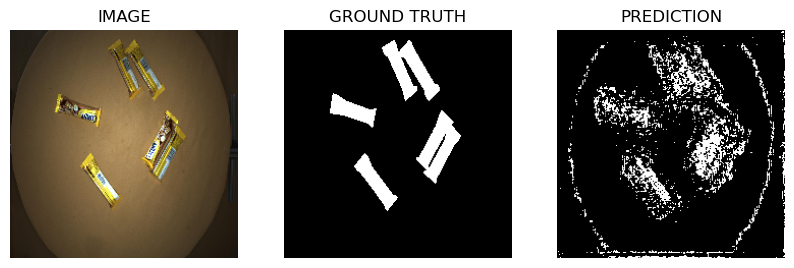

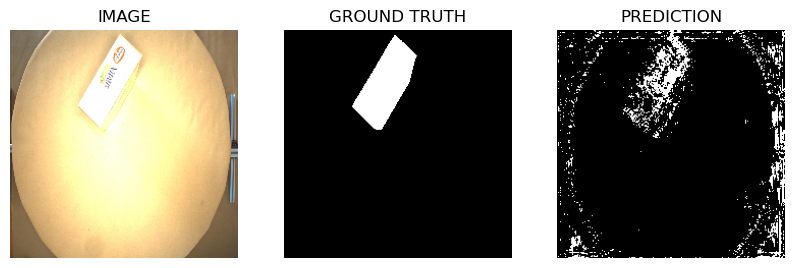

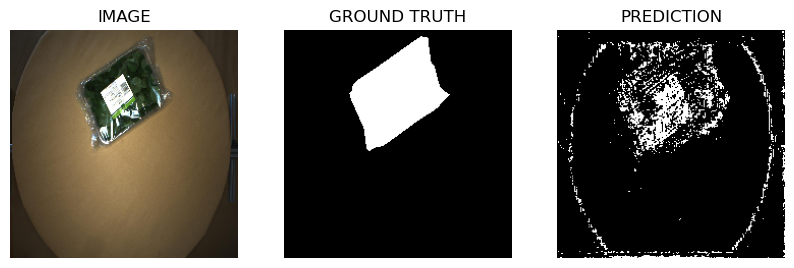

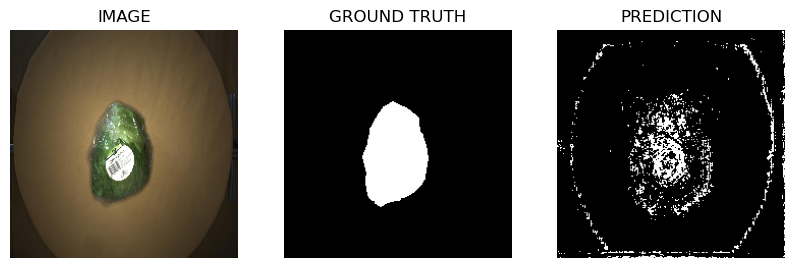

In [21]:
# Compare predictions with original
for i in range(len(val_data)):
    image, mask, pred_mask = make_inference(i)


    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

In [52]:
def compute_confusion_matrix(mask, pred_mask):
    # Flatten the masks
    mask_flat = mask.flatten()
    pred_mask_flat = pred_mask.flatten()
    
    mask_flat = (mask_flat > 0.001).astype(int)
    pred_mask_flat = (pred_mask_flat > 0.001).astype(int)
    
    cm = confusion_matrix(mask_flat, pred_mask_flat, labels=[0, 1])
    return cm

total_cm = np.zeros((2, 2), dtype=int)    
for i in range(len(val_data)):
    image, mask, pred_mask = make_inference(i)
    cm = compute_confusion_matrix(mask.cpu().numpy(), pred_mask.cpu().numpy())
    total_cm+=cm

print(f"Confusion Matrix: \n {total_cm}")

tn, fp, fn, tp = total_cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Confusion Matrix: 
 [[172406  10108]
 [ 10791   7399]]
Accuracy: 0.90
Precision: 0.42
Recall: 0.41
